## **컨브넷 이미지 시각화2**

컨브넷이 학습한 필터를 조사하는 방법 중 하나는, 각 필터가 반응하는 시각적 패턴을 그려 보는 것이다. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화 하기 위해 컨브넷 입력 이미지에 경사 상승법을 적용한다. 결과적으로 입력 이미지는 선택된 필터가 최대로 응답하는 이미지가 될 것이다.

결과 값을 통해, VGG16 이미지 넷의 컨브넷 필터들은 모델의 상위층으로 갈 수록 점점 더 복잡해지고 개선된다는 것을 알 수 있다. (학습하는 이미지 패턴이 구체화되는 것이다.)

<br>

### **[Gradient clipping]**
* 여기에서는 경사 상승법을 구현하기 전에, 그래디언트 텐서를 L2 노름으로 정규화 하는 gradient clipping 기법을 사용하였다. gradient clipping으로 처리된 그래디언트의 L2 노름은 항상 1이 되므로, 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있다.

```python
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # gradient clipping
```







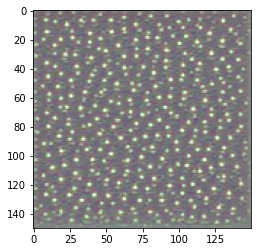

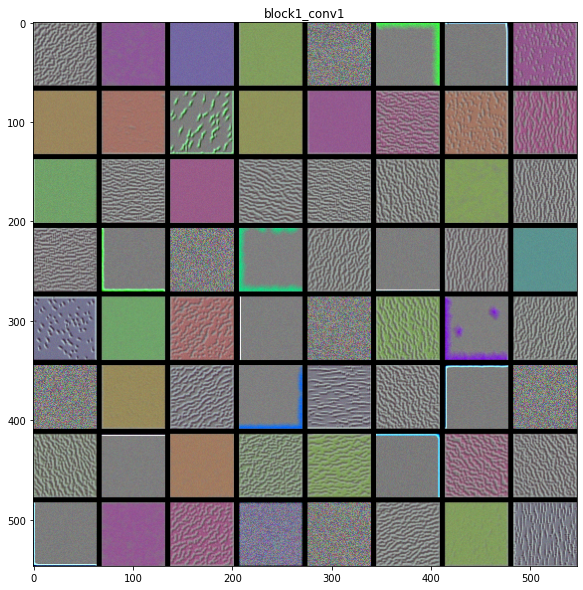

<Figure size 432x288 with 0 Axes>

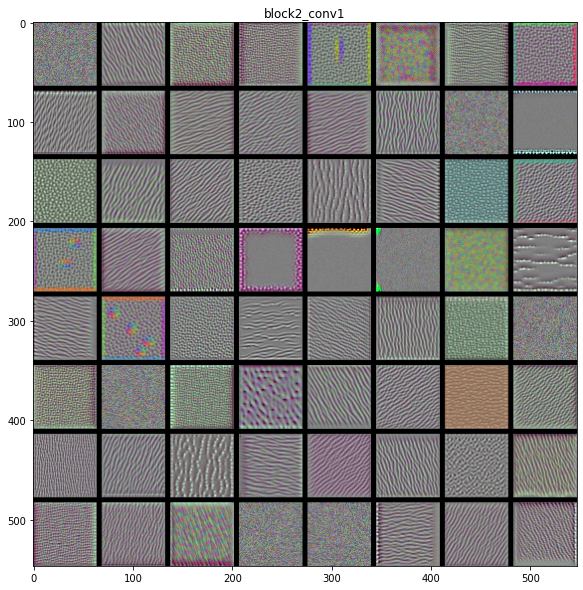

<Figure size 432x288 with 0 Axes>

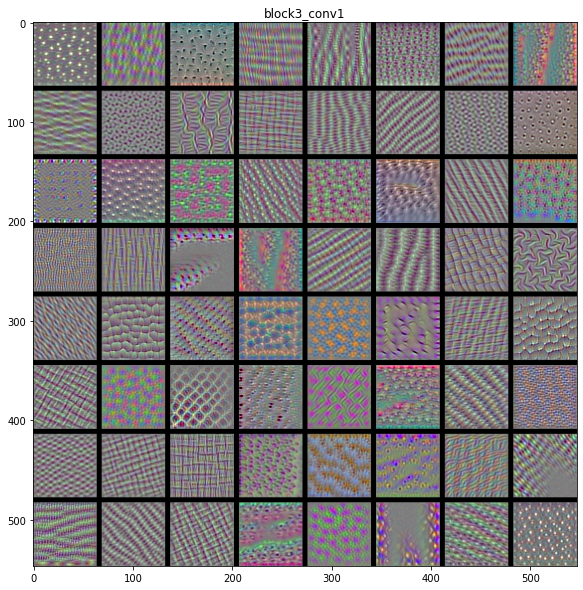

<Figure size 432x288 with 0 Axes>

In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import VGG16
from keras import backend as K # 케라스 백엔드 함수
tf.compat.v1.disable_eager_execution()

model = VGG16(weights = 'imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

# 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:, :, :, filter_index])

  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # gradient clipping

  iterate = K.function([model.input], [loss, grads])
  input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. # 잡음이 섞인 흰색 이미지로 시작한다.

  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += step * grads_value
  
  img = input_img_data[0]
  return deprocess_image(img)

plt.imshow(generate_pattern(layer_name, filter_index))

layer_name_arr = ['block1_conv1', 'block2_conv1', 'block3_conv1']

size = 64
margin = 5
for layer_name in layer_name_arr:
  results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

  for i in range(8):
    for j in range(8):
      filter_img = generate_pattern(layer_name, i + (j*8), size=size)

      horizontal_start = i * size + i * margin
      horizontal_end = horizontal_start + size
      vertical_start = j * size + j * margin
      vertical_end = vertical_start + size
      results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

  plt.figure(figsize=(10, 10))
  plt.imshow(results)
  plt.title(layer_name)

  plt.figure() 

